In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

In [76]:
amba = pd.read_csv('./data/AMBA.csv')

In [77]:
print(amba.shape)

(2853, 7)


In [78]:
amba.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-10-11,6.06,6.44,6.00,6.08,6.08,416700
1,2012-10-12,6.05,6.30,6.01,6.23,6.23,155200
2,2012-10-15,6.35,6.40,6.05,6.15,6.15,156700
3,2012-10-16,6.15,6.30,5.94,6.01,6.01,173000
4,2012-10-17,6.00,6.08,5.99,6.00,6.00,113600


The min open/close price of AMBA is 6.00000
The max open/close price of AMBA is 216.660004 and 216.839996 respectively

In [79]:
amba.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2.853000e+03
mean,59.399888,60.739012,58.063505,59.403645,59.403645,1.004999e+06
std,33.523402,34.412228,32.559028,33.471636,33.471636,1.204699e+06
min,6.000000,6.080000,5.550000,6.000000,6.000000,1.890000e+04
25%,40.040001,40.990002,39.150002,40.090000,40.090000,4.201000e+05
50%,53.720001,54.740002,52.680000,53.680000,53.680000,6.554000e+05
75%,70.199997,72.059998,68.570000,70.190002,70.190002,1.116200e+06
max,216.660004,227.589996,209.050003,216.839996,216.839996,2.507260e+07


Understand the basic overview information about our dataframe

In [80]:
amba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2853 non-null   object 
 1   Open       2853 non-null   float64
 2   High       2853 non-null   float64
 3   Low        2853 non-null   float64
 4   Close      2853 non-null   float64
 5   Adj Close  2853 non-null   float64
 6   Volume     2853 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 156.2+ KB


Confirm null-values

In [81]:
amba.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Understand the data types that we are working with in our data

In [82]:
amba.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Exploratory Analysis

Determine Mid price pricing trend

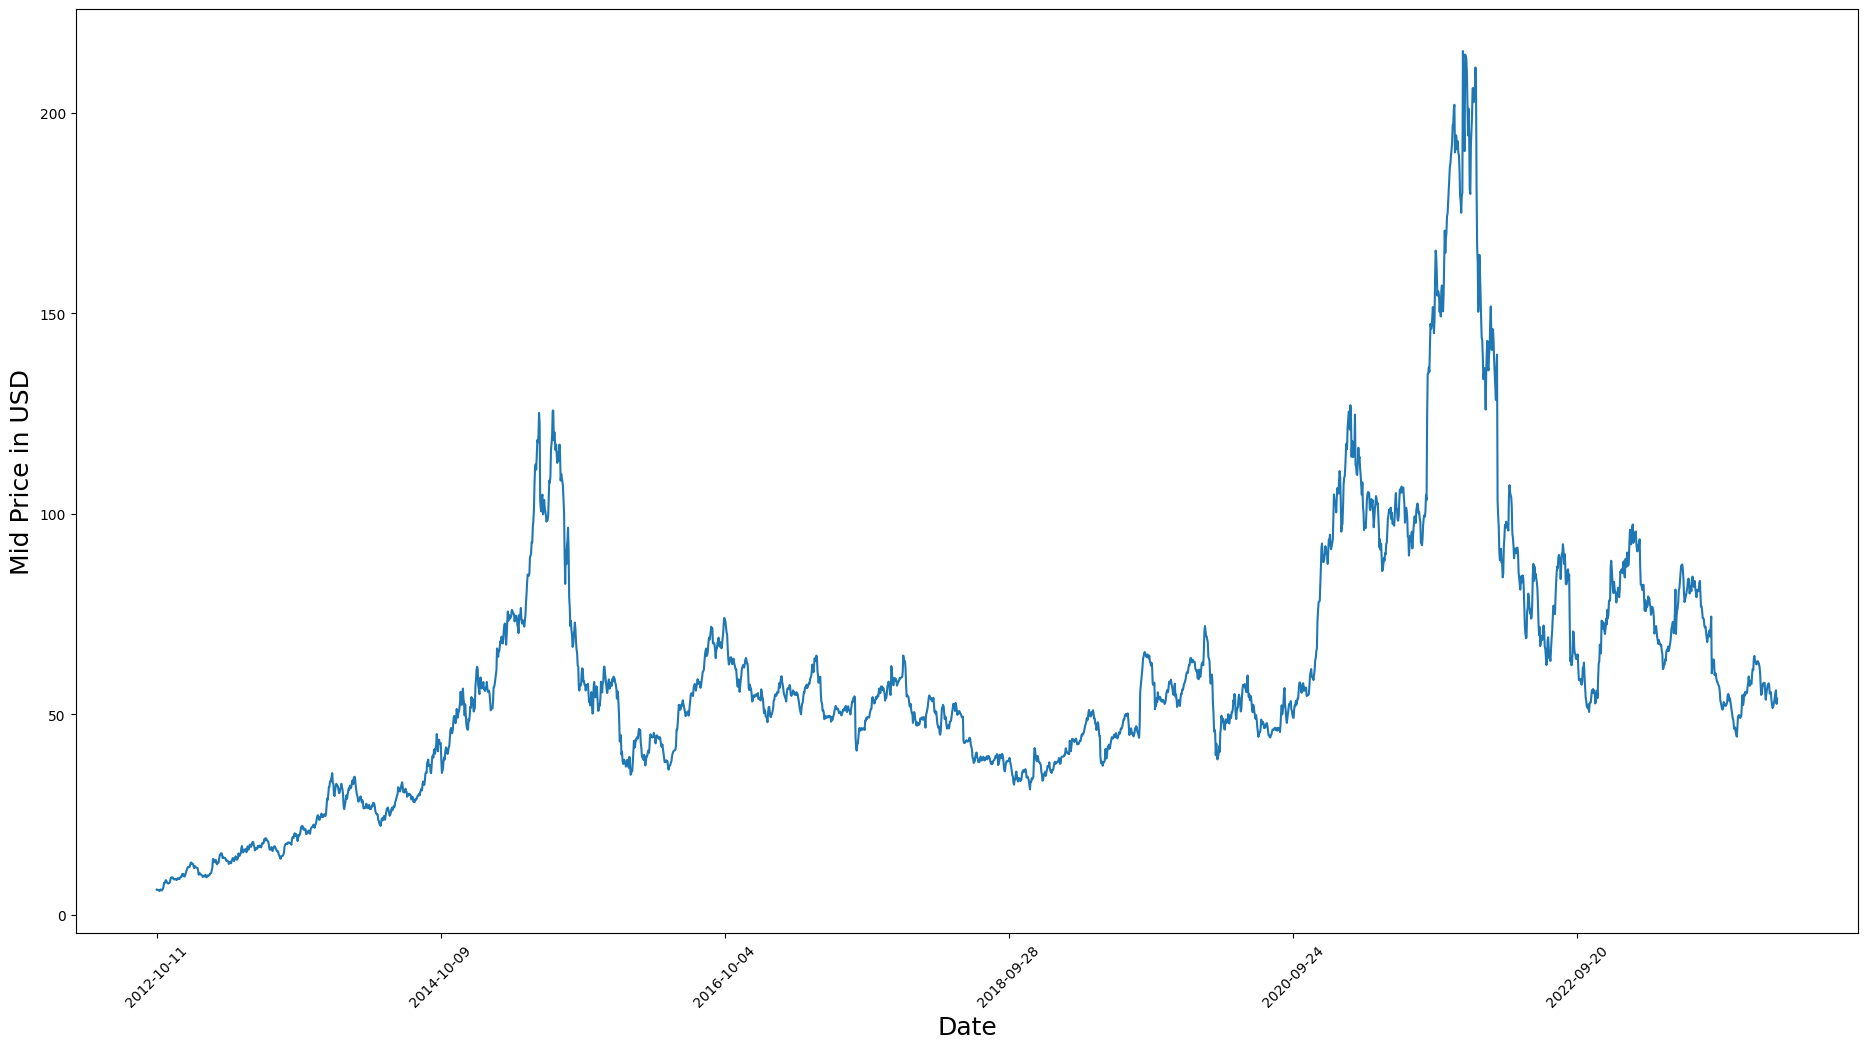

In [83]:
plt.figure(figsize=(23, 12))
plt.plot(range(amba.shape[0]), (amba['Low'] + amba['High']) / 2.0)
plt.xticks(range(0, amba.shape[0], 500), amba['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price in USD', fontsize=18)
plt.show()

Determine close price trends

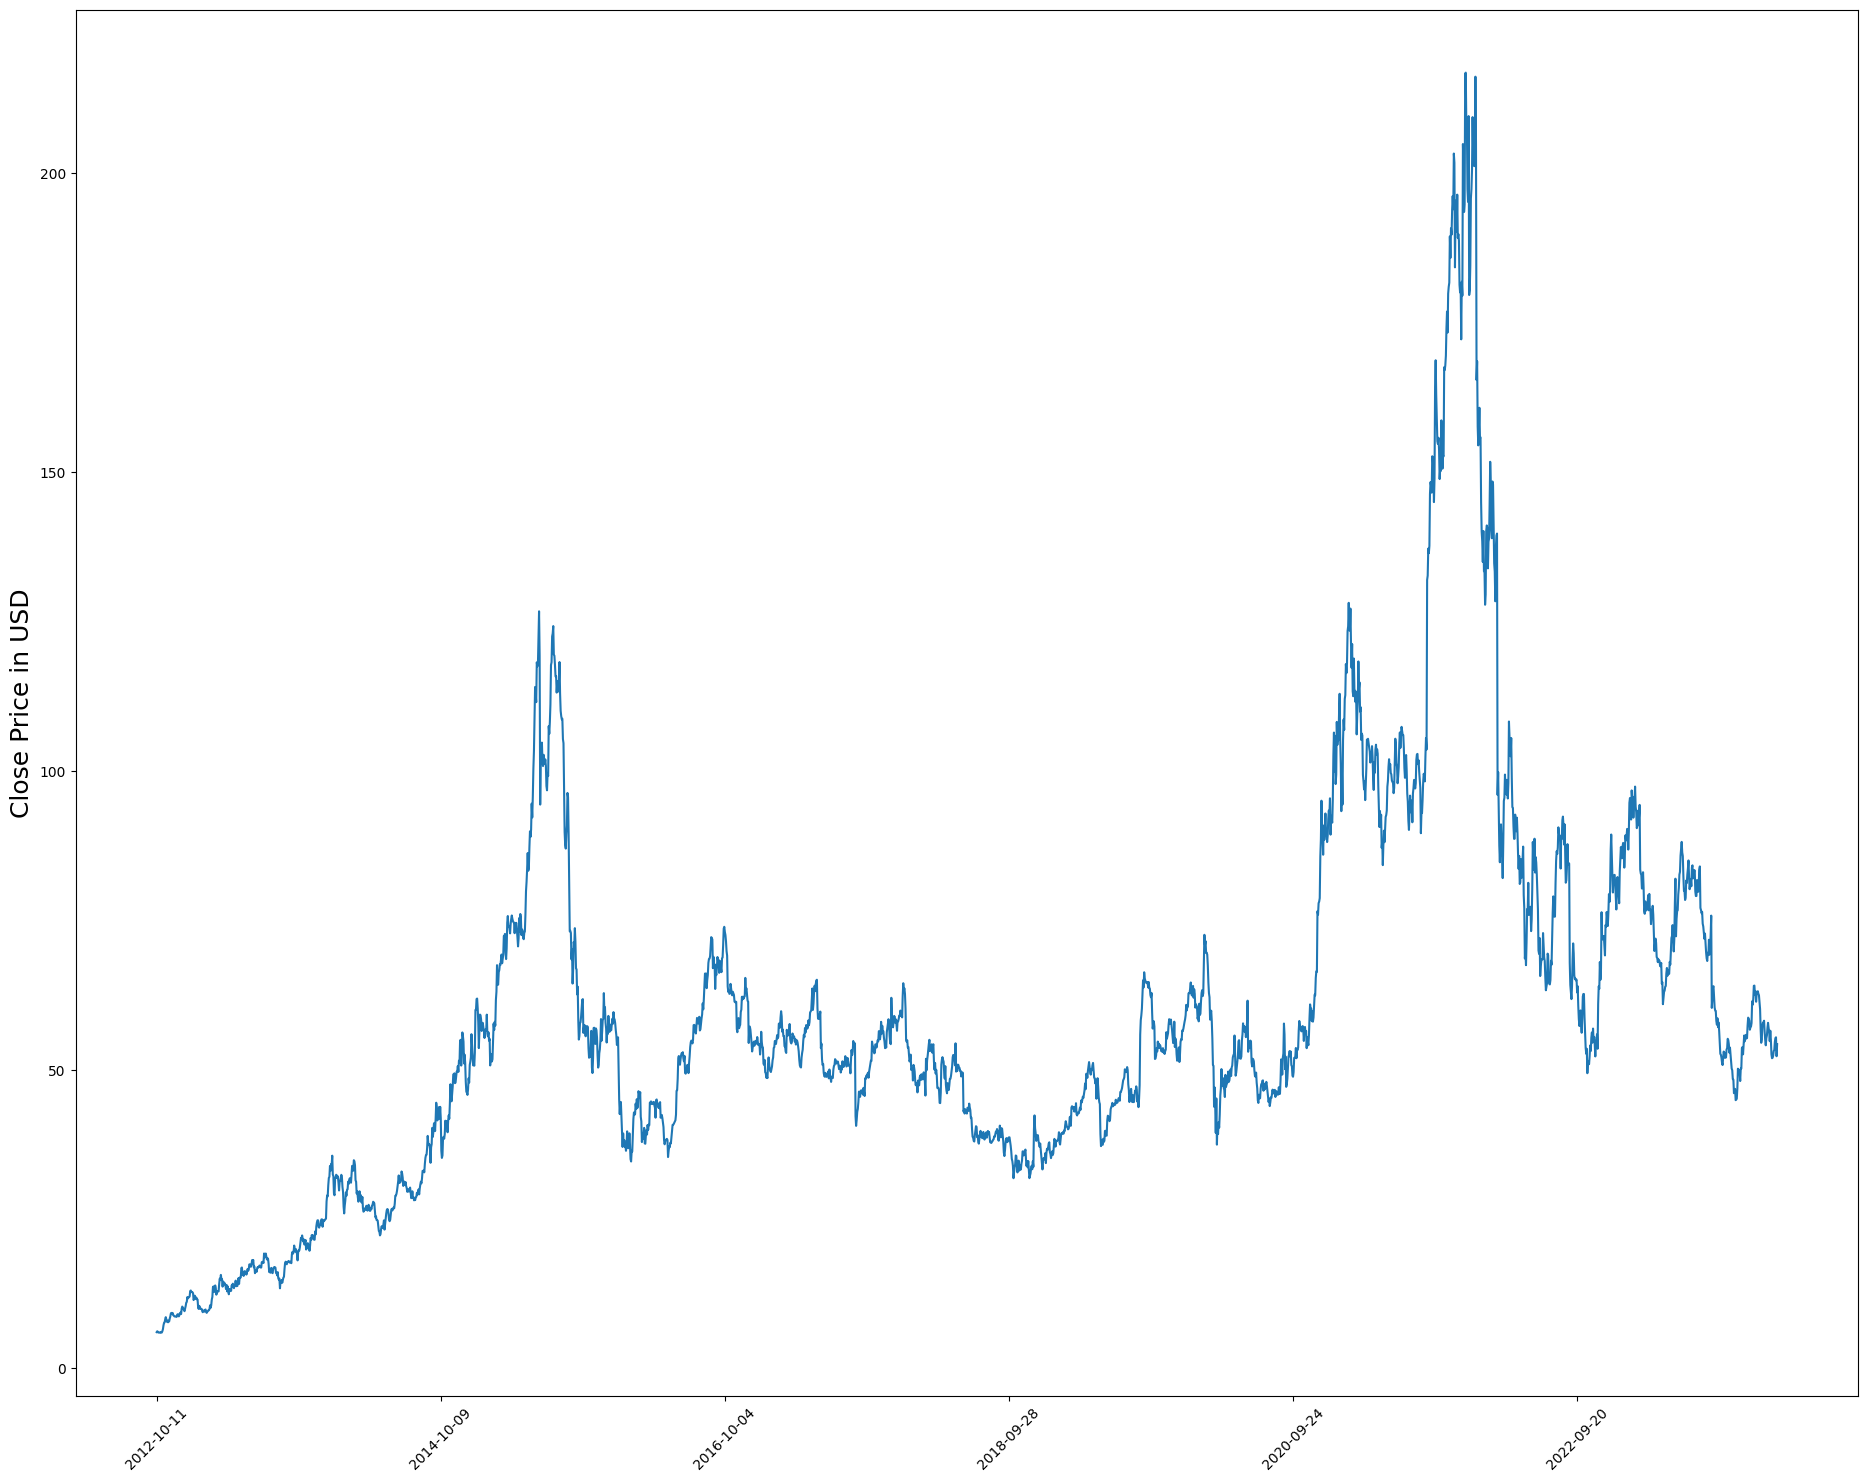

In [84]:
plt.figure(figsize=(23, 18))
plt.plot(amba['Close'])
plt.xticks(range(0, amba.shape[0], 500), amba['Date'].loc[::500], rotation=45)
plt.ylabel('Close Price in USD', fontsize=18)
plt.show()

100 day closing price moving averages and 200 day moving averages closing price

Noted that 100 day rolling average appears to follow historical close price trend more closely than 200 day rolling average

Text(0.5, 1.0, 'Comparision of 100 and 200 Day Moving Average Closing Price')

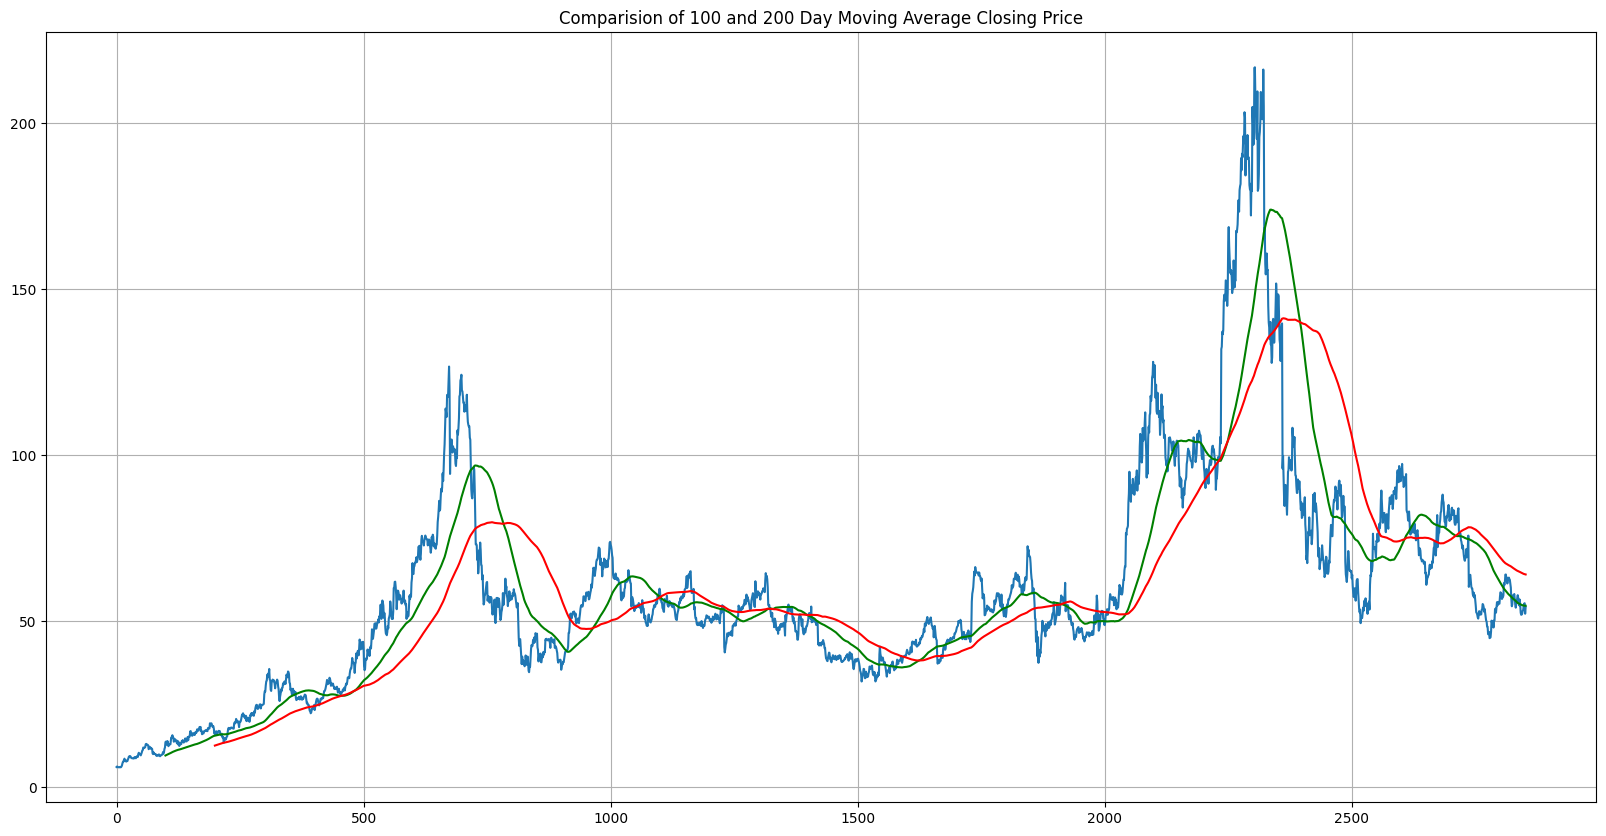

In [85]:
average_100 = amba['Close'].rolling(100).mean()
average_100

average_200 = amba['Close'].rolling(200).mean()
average_200

plt.figure(figsize=(20,10))
plt.plot(amba['Close'])
plt.plot(average_100, 'g')
plt.plot(average_200, 'r')
plt.grid(True)
plt.title('Comparision of 100 and 200 Day Moving Average Closing Price')

Overview of pricing and volume trends based on Open, High, Low, Close, Volume

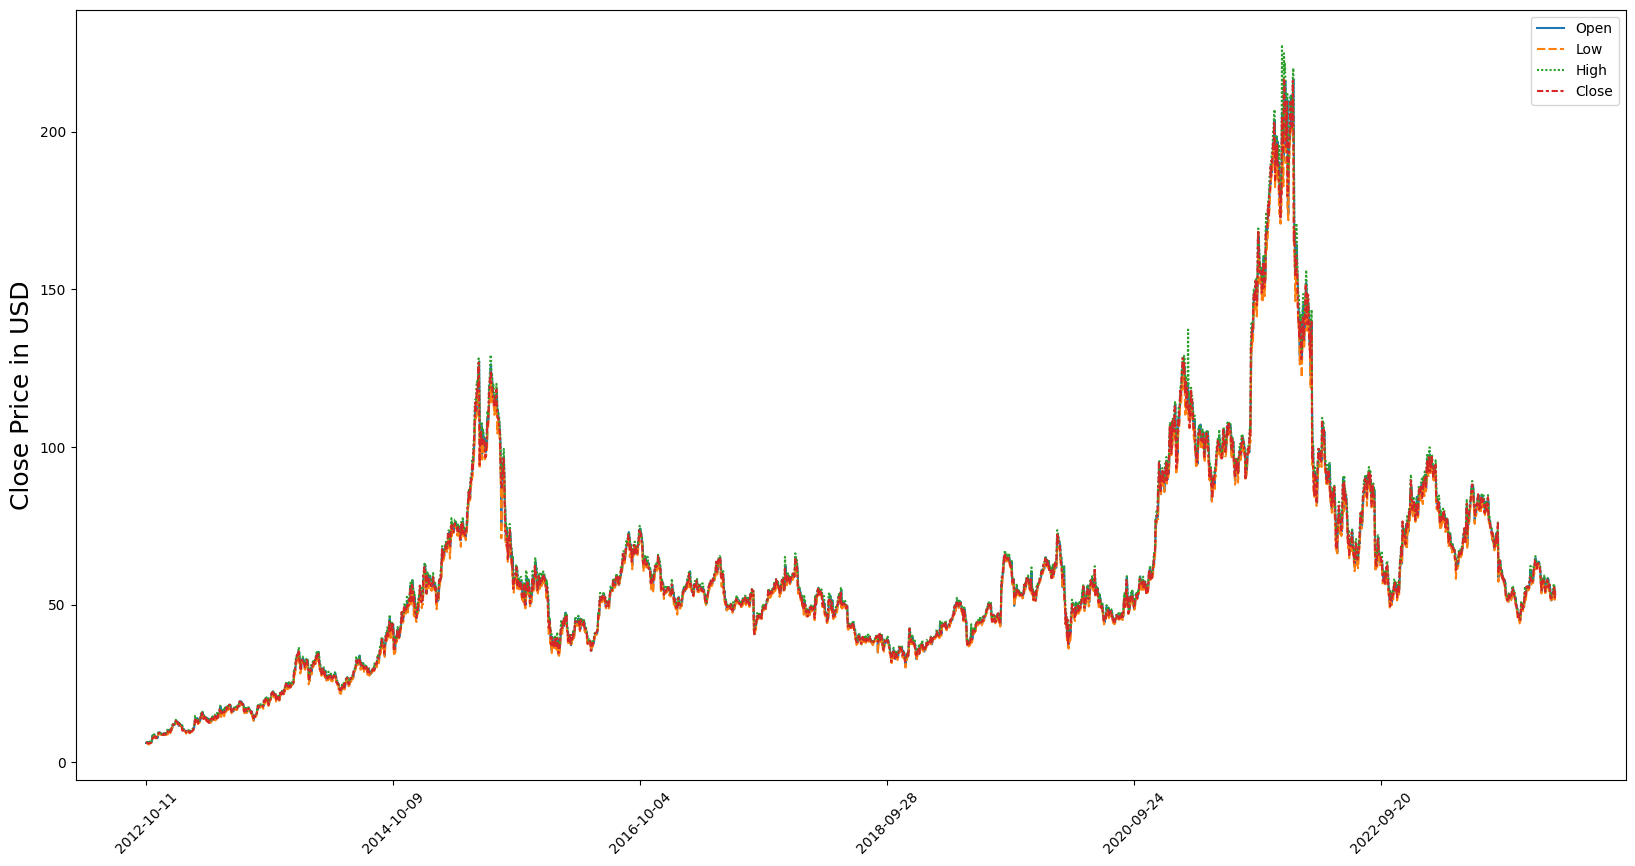

In [86]:
# Plot Multi lines
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.xticks(range(0, amba.shape[0], 500), amba['Date'].loc[::500], rotation=45)
plt.ylabel('Close Price in USD', fontsize=18)
ax = sb.lineplot(data=amba[['Open', 'Low', 'High', 'Close']])

Because Date is an object, we want to split the Date into new columns: Year, Month, and Day and store the values as an integer type

In [87]:
# Split the 'Date' column and handle errors
try:
    splitted = amba['Date'].str.split('-', expand=True)
except Exception as e:
    print("Error occurred during splitting:")
    print(e)

# If splitting was successful, proceed with data processing
if 'splitted' in locals():
    try:
        amba['Year'] = splitted[0].astype('int')
        amba['Month'] = splitted[1].astype('int')
        amba['Day'] = splitted[2].astype('int')
    except Exception as e:
        print("Error occurred during data processing:")
        print(e)

# Display the DataFrame head
print(amba.head())

         Date  Open  High   Low  Close  Adj Close  Volume  Year  Month  Day
0  2012-10-11  6.06  6.44  6.00   6.08       6.08  416700  2012     10   11
1  2012-10-12  6.05  6.30  6.01   6.23       6.23  155200  2012     10   12
2  2012-10-15  6.35  6.40  6.05   6.15       6.15  156700  2012     10   15
3  2012-10-16  6.15  6.30  5.94   6.01       6.01  173000  2012     10   16
4  2012-10-17  6.00  6.08  5.99   6.00       6.00  113600  2012     10   17


We want to see if quarter end has an influence on stock pricing. We will divide the Month value by 3 to determine if it is a quarter end month and store into a column called 'is_quarter_end'. 

If it is a quarter end month, we assign a value of 1. If not, we assign a quarter end value of 0.

In [88]:
amba['is_quarter_end'] = np.where(amba['Month']%3==0, 1, 0)
amba.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,is_quarter_end
0,2012-10-11,6.06,6.44,6.00,6.08,6.08,416700,2012,10,11,0
1,2012-10-12,6.05,6.30,6.01,6.23,6.23,155200,2012,10,12,0
2,2012-10-15,6.35,6.40,6.05,6.15,6.15,156700,2012,10,15,0
3,2012-10-16,6.15,6.30,5.94,6.01,6.01,173000,2012,10,16,0
4,2012-10-17,6.00,6.08,5.99,6.00,6.00,113600,2012,10,17,0


Observe pricing and volume trends based on quarter end.

Note that the stock prices are higher on quarter ending but volume is lower.

In [89]:
amba.filter(items=['is_quarter_end', 'Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Month', 'Year']).groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,Day,Month,Year
is_quarter_end,,,,,,,,
0,58.507171,59.767135,57.228686,58.512992,8.431833e+05,15.720294,6.098318,2017.973712
1,61.185321,62.682765,59.733144,61.184953,1.328630e+06,15.754995,7.533123,2017.895899


View pricing trends based on the average yearly price. The average yearly trend pricing is divided into four featured histogram charts: Open price, High price, Low price, Close price. 


Note that between years 2014 and 2015 AND years 2020 and 2021, the stock price doubled. Also note that there has been a steady decline in price from 2022 and onward.

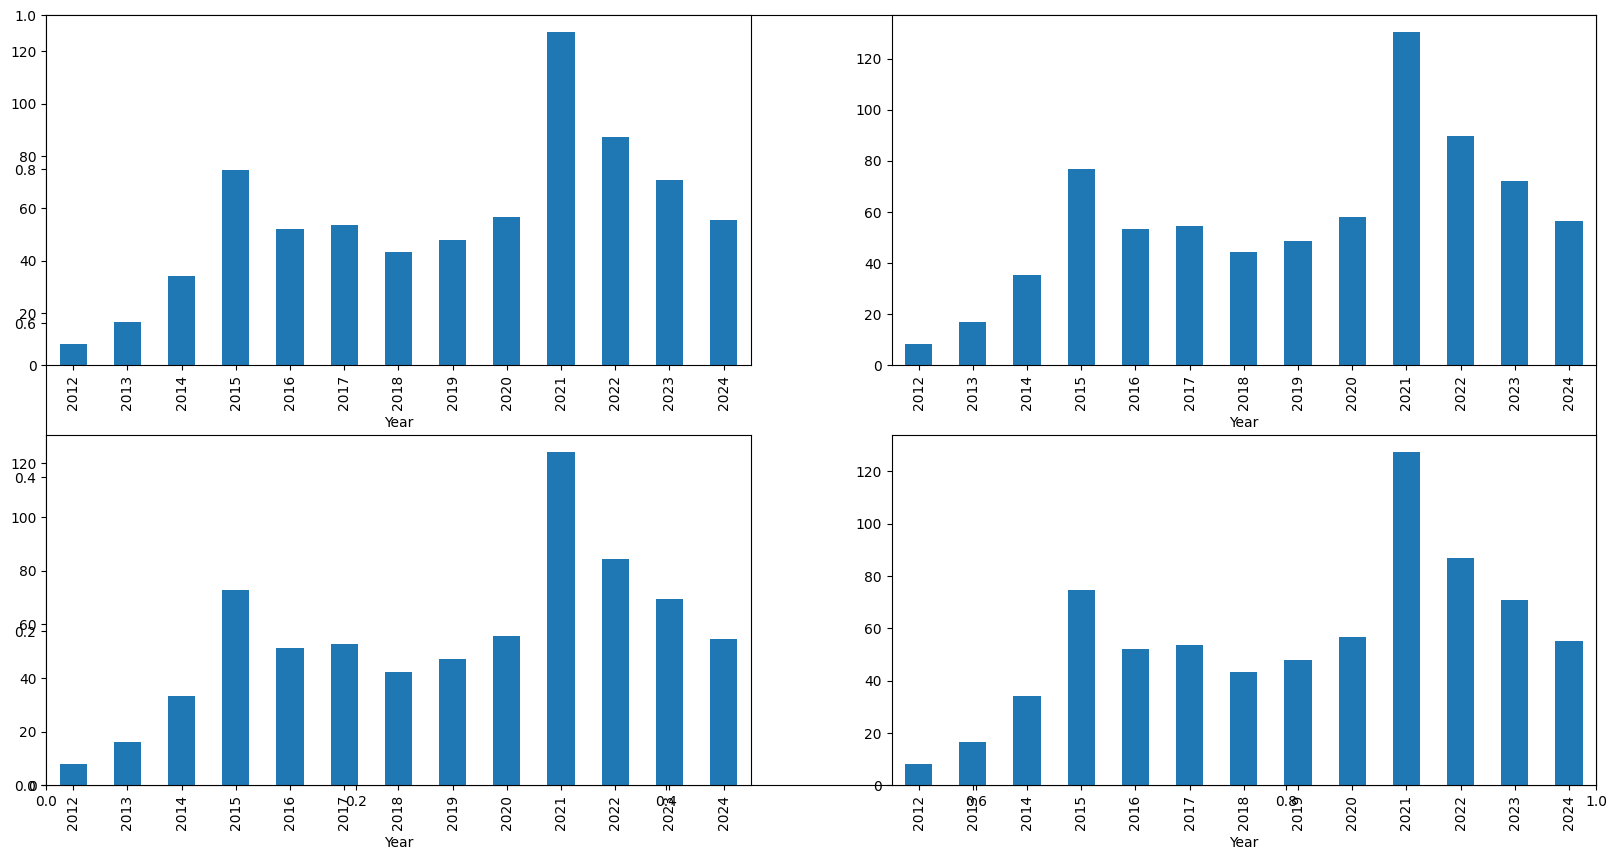

In [90]:
data_grouped = amba.filter(items=["Year", "Open", "High", "Low", "Close"]).groupby("Year").mean()

plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

Added additional columns: Volume_Increase_Decrease, 'Open_Buy_Sell', 'Buy_Sell', 'Returns' to futher explore relationships between historical pricing trends and to help model better predict stock price

In [91]:
# If the volume of the next day (shifted by one row using shift(-1)) is greater than the current day's volume. If it is, it assigns 'Increase' to the new column; otherwise, it assigns 'Decrease'.
amba['Volume_Increase_Decrease]'] = np.where(amba['Volume'].shift(-1) > amba['Volume'], 'Increase', 'Decrease')

# If the open price of the next day (shifted by one row using shift(-1)) is greater than the current day's open price. If it is, it assigns '1' to the new column; otherwise, it assigns '0'.
# A value of 1 = Buy and a values of 0 = Sell
amba['Open_Buy_Sell'] = np.where(amba['Open'].shift(-1) > amba['Open'], 1, 0)

# If the close price of the next day (shifted by one row using shift(-1)) is greater than the current day's close price. If it is, it assigns '1' to the new column; otherwise, it assigns '0'.
# A value of 1 = Buy and a values of 0 = Sell
amba['Buy_Sell'] = np.where(amba['Close'].shift(-1) > amba['Close'], 1, 0)

# pct_change() computes the fractional change from the immediately previous row by default. 
# This is useful in comparing the fraction of change in a time series of elements.
amba['Returns'] = amba['Close'].pct_change()
amba = amba.dropna()
amba.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,is_quarter_end,Volume_Increase_Decrease],Open_Buy_Sell,Buy_Sell,Returns
1,2012-10-12,6.05,6.30,6.01,6.23,6.23,155200,2012,10,12,0,Increase,1,0,0.024671
2,2012-10-15,6.35,6.40,6.05,6.15,6.15,156700,2012,10,15,0,Increase,0,0,-0.012841
3,2012-10-16,6.15,6.30,5.94,6.01,6.01,173000,2012,10,16,0,Decrease,0,0,-0.022764
4,2012-10-17,6.00,6.08,5.99,6.00,6.00,113600,2012,10,17,0,Increase,1,0,-0.001664
5,2012-10-18,6.20,6.20,5.55,6.00,6.00,247300,2012,10,18,0,Decrease,0,0,0.000000


Created a heatmap in order to better understand if there are any strong correlations between different features and factors in our data

<Axes: >

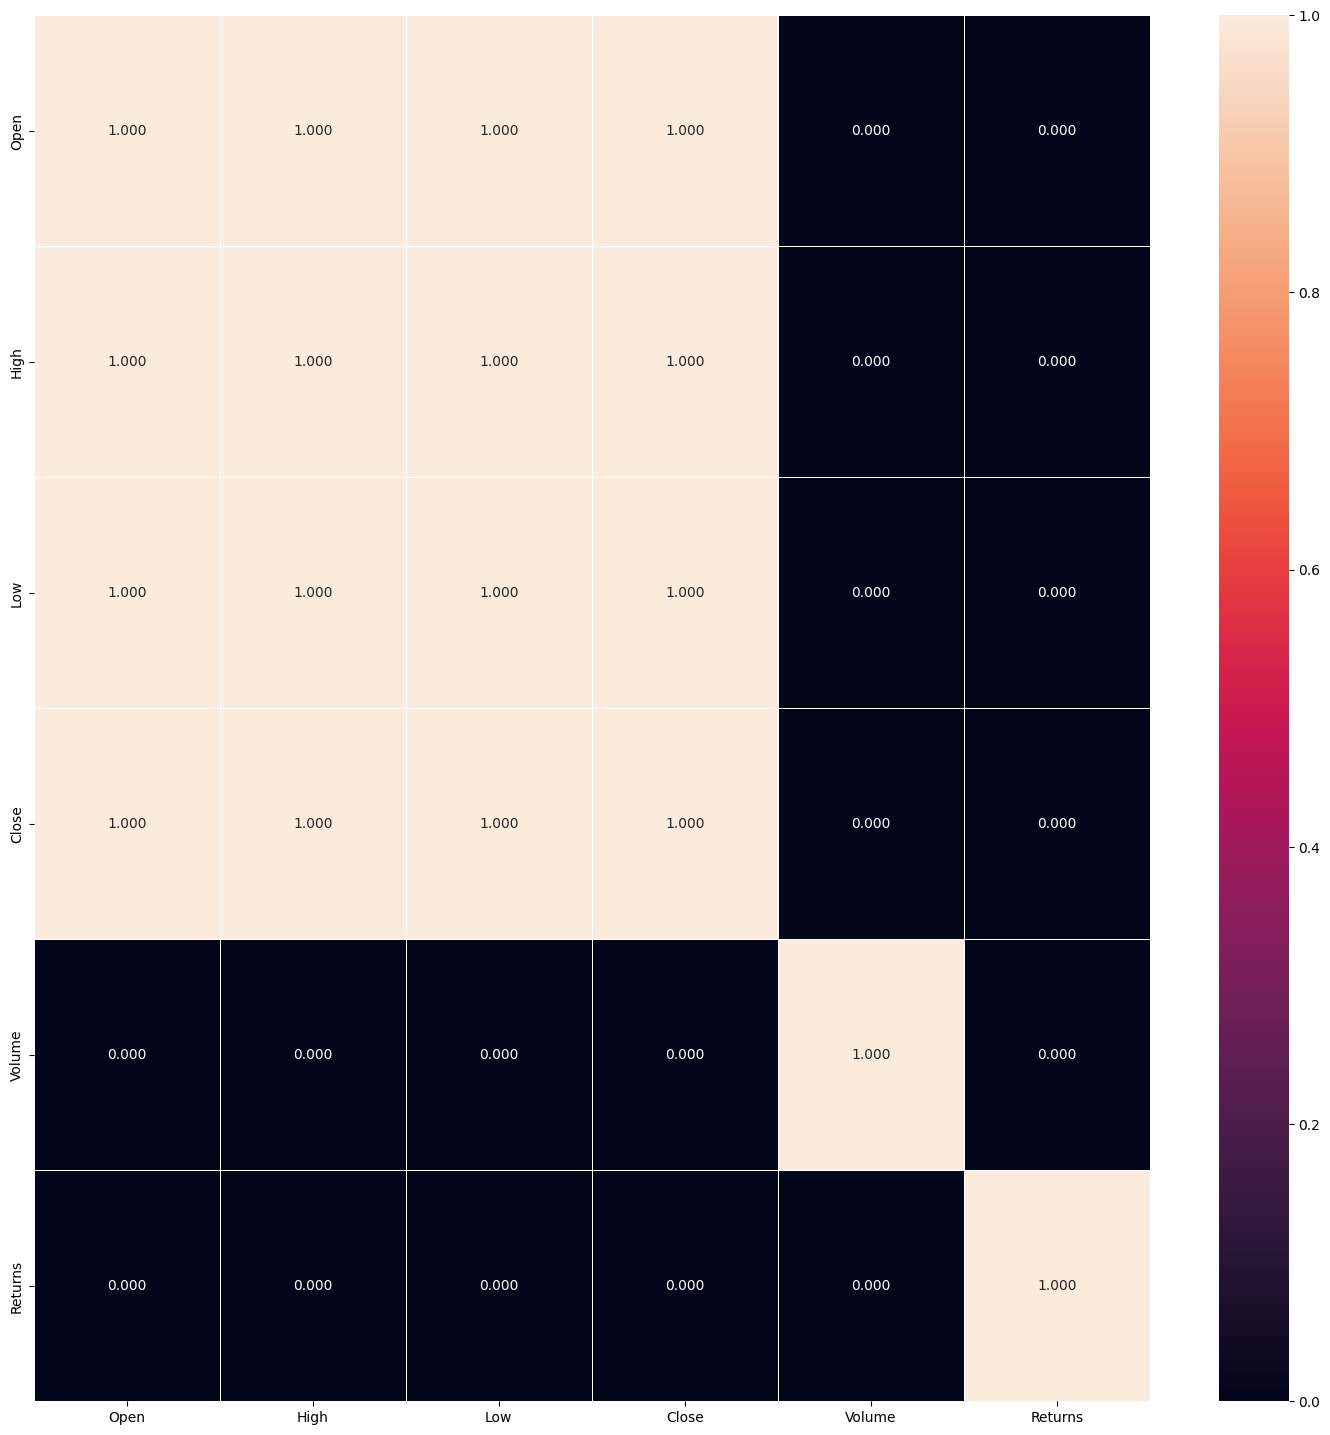

In [92]:
f,ax = plt.subplots(figsize=(18, 18))
sb.heatmap(amba[['Open', 'High', 'Low', 'Close', 'Volume', 'Returns']].corr() > 0.9, annot=True, linewidths=.5, fmt= '.3f',ax=ax)

Splitting our data in training and testing sets

In [93]:
# # X are the features that we use as input
# X = amba[['Open', 'High', 'Low', 'Close', 'Volume']]

# # y is the target that we want to output
# y = amba['Adj Close']
amba_train = pd.DataFrame(amba[0:int(len(amba) * 0.8)])
amba_test = pd.DataFrame(amba[int(len(amba) * 0.8): int(len(amba))])

print(amba_train.shape)
print(amba_test.shape)



(2281, 15)
(571, 15)


# Normalize our Dataset

We will focus on the historical closing prices of AMBA as the source of our data and then scale the data the normalize it.

In [94]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_close = amba_train.iloc[:, 4:5].values
test_close = amba_test.iloc[:, 4:5].values

amba_scaled = scaler.fit_transform(train_close)

In [95]:
X_train = []
y_train = []

for i in range(100, amba_scaled.shape[0]):
    X_train.append(amba_scaled[i - 100: i])
    y_train.append(amba_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# X_test = []
# y_test = []

# for i in range(100, amba_scaled.shape[0]):
#     X_test.append(amba_scaled[i - 100: i])
#     y_test.append(amba_scaled[i, 0])

# X_test, y_test = np.array(X_test), np.array(y_test)

print(f'X training set: {X_train.shape}')

X training set: (2181, 100, 1)


# Create our model

In [96]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

# Training Our Model

In [97]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
69/69 [==============================] - 10s 85ms/step - loss: 0.0155 - mean_absolute_error: 0.0827
Epoch 2/100
69/69 [==============================] - 7s 100ms/step - loss: 0.0038 - mean_absolute_error: 0.0424
Epoch 3/100
69/69 [==============================] - 6s 85ms/step - loss: 0.0031 - mean_absolute_error: 0.0385
Epoch 4/100
69/69 [==============================] - 6s 85ms/step - loss: 0.0031 - mean_absolute_error: 0.0380
Epoch 5/100
69/69 [==============================] - 6s 85ms/step - loss: 0.0029 - mean_absolute_error: 0.0364
Epoch 6/100
69/69 [==============================] - 6s 86ms/step - loss: 0.0029 - mean_absolute_error: 0.0372
Epoch 7/100
69/69 [==============================] - 6s 94ms/step - loss: 0.0024 - mean_absolute_error: 0.0335
Epoch 8/100
69/69 [==============================] - 6s 90ms/step - loss: 0.0022 - mean_absolute_error: 0.0322
Epoch 9/100
69/69 [==============================] - 6s 92ms/step - loss: 0.0025 - mean_absolute_error: 0.0336

In [98]:
model.save('keras_model')

INFO:tensorflow:Assets written to: keras_model/assets


INFO:tensorflow:Assets written to: keras_model/assets


In [99]:
test_close.shape

(571, 1)

Create a Data frame called last_100_days to view the last 100 elements/days of our 'train_close' closing prices array of our training set

In [100]:
last_100_days = pd.DataFrame(train_close[-100:])

Create a DataFrame called test_df from our 'test_close' closing prices array of our test set

In [101]:
test_df = pd.DataFrame(test_close)

Create a DataFrame called 'final_close_df' that combines rows from our DF last_100_days of closing with the rows from our DF test_df with the index reset to ensure a continuous integer index

In [102]:
final_close_df = pd.concat([last_100_days, test_df], ignore_index = True)

final_close_df.head()

,0
0,101.300003
1,100.699997
2,97.930000
3,99.070000
4,100.650002


Create an array called input_data that takes in the values of our DF final_close_df, which is normalized by using our scaler

In [103]:
input_data = scaler.fit_transform(final_close_df)

In [104]:
input_data.shape

(671, 1)

# Testing the model

In [105]:

test_dataset = pd.read_csv('./data/AMBA.csv')

real_stock_price = test_dataset.iloc[:, 1:2].values

In [106]:
X_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    X_test.append(input_data[i - 100: i])
    y_test.append(input_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f'X testing set: {X_test.shape}')

X testing set: (571, 100, 1)


# Making Predictions

In [107]:
y_pred = model.predict(X_test)


18/18 [==============================] - 1s 25ms/step


In [113]:
y_pred.shape

y_pred = scaler.inverse_transform(y_pred)

In [114]:
y_test

array([8.67046640e-01, 9.21251637e-01, 9.12236847e-01, 8.10515284e-01,
       8.62684653e-01, 8.75596140e-01, 8.45411179e-01, 8.81237649e-01,
       8.39188118e-01, 8.42852216e-01, 8.36280127e-01, 7.93474496e-01,
       7.86088174e-01, 7.92776607e-01, 7.40432764e-01, 7.96498830e-01,
       7.82947579e-01, 9.30499026e-01, 9.04094506e-01, 8.64371334e-01,
       8.71641312e-01, 9.98953170e-01, 1.00000000e+00, 9.47830631e-01,
       9.47481689e-01, 8.86646559e-01, 8.74258487e-01, 9.57717871e-01,
       7.83587343e-01, 7.88007455e-01, 8.12201965e-01, 8.77631768e-01,
       8.86646559e-01, 9.05432159e-01, 9.56729078e-01, 9.23636213e-01,
       9.29742925e-01, 9.08979908e-01, 9.18867061e-01, 9.96045178e-01,
       9.31371389e-01, 7.00825847e-01, 7.19088027e-01, 6.55461254e-01,
       6.37257199e-01, 6.52262446e-01, 6.73839694e-01, 6.44352704e-01,
       6.45108810e-01, 5.81598206e-01, 5.53216269e-01, 5.43910662e-01,
       5.23729197e-01, 5.53914158e-01, 5.14656276e-01, 5.14190992e-01,
      

In [109]:
print(f'The mean accuracy of this test model is: {model.score(X_test, y_test)}')
train_predictions = model.predict(X_train)
#train_model_mse = np.sqrt(mean_squared_error(y_test, train_predictions))
train_model_mse = np.sqrt(mean_squared_error(y_train, train_predictions))
print(f'Training RMSE: {train_model_mse}')

AttributeError: 'Sequential' object has no attribute 'score'

In [ ]:
test_predictions = model.predict(X_test)
test_model_mse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'Testing RMSE: {test_model_mse}')

Testing RMSE: 0.5594161531081258


In [ ]:
last_date = amba.index[-1]
next_date = last_date + pd.Timedelta(days=1)
next_data = pd.DataFrame(index=[next_date], columns=amba.columns)
next_data['Day'] = next_date.day
next_data['Month'] = next_date.month
next_data['Year'] = next_data.year

prediction = model.predict(next_data)
print(f'Predicted stock price for the next day: {prediction}')

TypeError: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'

In [ ]:
















y_predict = model.predict(X_test)
y_predict
Evaluating the accuracy of three types of models: LogisticRegression, SVC, and XGBCClassifier
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, y_train)

    print(f'{models[i]} : ' )
    print('Training accuracy: ', metrics.roc_auc_score(y_train, models[i].predict_proba(X_train)[:, 1]))
    print('Validation accuracy: ', metrics.roc_auc_score(y_test, models[i].predict_proba(X_test)[:, 1]))
    print()
Predicting whether to buy or sell based on predictions using our three models and inputing: Open, High, Low, Close, Volume of previous trading day
# input the latest Open, High, Low, Close, Volume
# predicts the next day price
#model.predict([[56.20, 58.29, 55.25, 57.16, 658500]])
new_data_point = [[56.20, 58.29, 55.25, 57.16, 658500]]

for model in models:
    if model.predict(new_data_point) == [1]:
        model_prediction = print('Buy')
    else:
        model_prediction = print('Sell')

    print(f'Prediction using {model}: {model.predict(new_data_point)}')